In [1]:
# import necessary packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.dates import drange
import seaborn as sns 
from arch import arch_model
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
sns.set
%matplotlib inline
plt.style.use('seaborn')

In [2]:
# import Gold, Equity(Vxus) and BTC data
#the entire year 2020
gld = pd.read_csv("C:/Users\BENEL ENERGY\PP\project 2\GLD (1).csv", index_col = 'Date', parse_dates = True)[['Adj Close']]
vxus = pd.read_csv("C:/Users\BENEL ENERGY\PP\project 2\VXUS (1).csv", index_col = 'Date', parse_dates = True)[['Adj Close']]
btc = pd.read_csv('C:/Users\BENEL ENERGY\PP\project 2\BTC-USD.csv', index_col = 'Date', parse_dates = True)[['Adj Close']]

#removing missing values
btc = btc.dropna()
vxus = vxus.dropna()
gld = gld.dropna()

In [3]:
#concatinating them together
df = pd.DataFrame(index = btc.index)
df['btc'] = btc['Adj Close']
start_date = '2020-01-01'
end_date = '2020-12-31'
df['gold'] = gld['Adj Close']
df['vxus'] = vxus['Adj Close']
df = df.dropna()


In [4]:
# first divide the assets by quarters

# Start of Q2 2020
Q2_Start = '2020-04-01'

# End of Q2 2020
Q2_End = '2020-06-30'

# Start of Q3 2020
Q3_Start = '2020-07-01'

# End of Q3 2020
Q3_End = '2020-09-30'

# Start of Q4 2020
Q4_Start = '2020-10-01'

# End of Q4 2020
Q4_End = '2020-12-31'

#data in quaters
df_Q2 = df[Q2_Start:Q2_End][['vxus', 'gold']]
df_Q3 = df[Q3_Start:Q3_End][['vxus', 'gold']]
df_Q4 = df[Q4_Start:Q4_End][['vxus', 'gold']]

### Pairs Trading 

In [5]:
X = df['gold']
y = df['vxus']

In [6]:
len(df)

249

In [7]:
x1 = sm.add_constant(X)#constant
model = sm.OLS(y,x1)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vxus   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     51.11
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           9.82e-12
Time:                        13:28:50   Log-Likelihood:                -743.71
No. Observations:                 249   AIC:                             1491.
Df Residuals:                     247   BIC:                             1498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.0526      3.893      5.664      0.000      14.384      29.721
gold           0.1666      0.023      7.149      0.000       0.121       0.213
==============================================================================
Omnibus:                       26.981   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.516
Skew:                           0.088   Prob(JB):                       0.0141
Kurtosis:                       2.111   Cond. No.                     2.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
#Calculating Spread()
testing_y = df
testing_y['Equity Prediction']=results.params[0]+((results.params[1])*testing_y.gold)
testing_y['Spread']=testing_y.vxus - (testing_y.gold*(results.params[1]))-(results.params[0])
testing_y.head()

,btc,gold,vxus,Equity Prediction,Spread
Date,,,,,
2020-01-02,6985.470215,143.949997,54.104733,46.039761,8.064972
2020-01-03,7344.884277,145.860001,53.441753,46.358036,7.083717
2020-01-06,7769.219238,147.389999,53.518623,46.612987,6.905636
2020-01-07,8163.692383,147.970001,53.422531,46.709636,6.712895
2020-01-08,8079.862793,146.860001,53.518623,46.524671,6.993952


In [9]:
testing_y['100_Day_Spread_Avg'] = testing_y[['Spread']].rolling(window=100).mean().dropna()
testing_y['100_Day_Spread_Stdev'] = testing_y.Spread.rolling(window=100).std().dropna()
testing_y['z-score']=(testing_y['Spread'] - testing_y['100_Day_Spread_Avg'])/(testing_y['100_Day_Spread_Stdev']).dropna()
testing_y=testing_y.dropna()
testing_y.head()

,btc,gold,vxus,Equity Prediction,Spread,100_Day_Spread_Avg,100_Day_Spread_Stdev,z-score
Date,,,,,,,,
2020-05-27,9181.017578,161.179993,45.421833,48.910888,-3.489055,-1.118854,6.267760,-0.378158
2020-05-28,9525.750977,161.720001,45.624180,49.000872,-3.376692,-1.233270,6.202511,-0.345573
2020-05-29,9439.124023,162.910004,45.681995,49.199169,-3.517174,-1.339279,6.149290,-0.354170
2020-06-01,10167.268555,163.660004,46.664814,49.324145,-2.659331,-1.434929,6.093888,-0.200923
2020-06-02,9529.803711,162.600006,47.358574,49.147512,-1.788938,-1.519947,6.038118,-0.044549


In [10]:
testing_y=testing_y[Q4_Start:Q4_End]
testing_y['Signal']=np.where(testing_y['z-score']>2, "buy(long) Bitcoin and sell(short) Equity",
                            np.where(testing_y['z-score']<-2, "buy Equity and sell Bitcoin",
                                     np.where(testing_y['z-score']<0.5, "sell the two stocks (limit our exposure)","Not Trade")))
testing_y.head()

,btc,gold,vxus,Equity Prediction,Spread,100_Day_Spread_Avg,100_Day_Spread_Stdev,z-score,Signal
Date,,,,,,,,,
2020-10-01,10623.330078,178.699997,51.257885,51.830340,-0.572455,-1.699351,1.568843,0.718298,Not Trade
2020-10-02,10585.164063,178.539993,51.033714,51.803678,-0.769964,-1.652380,1.524589,0.578789,Not Trade
2020-10-05,10804.000977,179.410004,51.784210,51.948652,-0.164442,-1.593607,1.465824,0.974991,Not Trade
2020-10-06,10621.664063,177.300003,51.413834,51.597051,-0.183217,-1.530809,1.387531,0.971216,Not Trade
2020-10-07,10679.136719,177.220001,51.930405,51.583720,0.346685,-1.459734,1.295935,1.393911,Not Trade


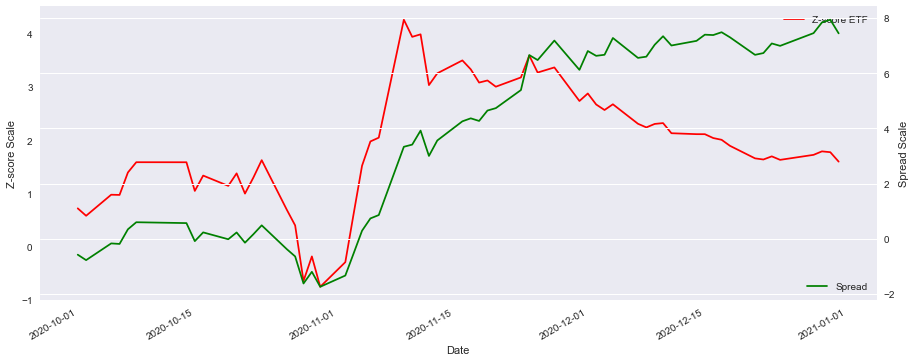

In [11]:
testing_y['z-score'].plot(figsize=(15,6), color= 'red', label='Z-score ETF').set_ylabel('Z-score Scale')
plt.legend(loc = "lower right")
testing_y['Spread'].plot(secondary_y= True, color = 'green',label ='Spread').set_ylabel('Spread Scale')
plt.legend(loc = "lower right")
plt.show()